In [15]:
import numpy as np
import pandas as pd
import pandas_datareader as web
import matplotlib.pyplot as plt
import math
import time
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error

In [2]:
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

In [3]:
stock = 'aapl' # Apple

df = pd.read_csv('../Data/Stocks/%s.us.txt' % stock, index_col=0)
df.drop('OpenInt', inplace=True, axis=1) # OpenInt column seems to be useless
print(df.shape)
df.head()

(8364, 5)


,Open,High,Low,Close,Volume
Date,,,,,
1984-09-07,0.42388,0.42902,0.41874,0.42388,23220030
1984-09-10,0.42388,0.42516,0.41366,0.42134,18022532
1984-09-11,0.42516,0.43668,0.42516,0.42902,42498199
1984-09-12,0.42902,0.43157,0.41618,0.41618,37125801
1984-09-13,0.43927,0.44052,0.43927,0.43927,57822062


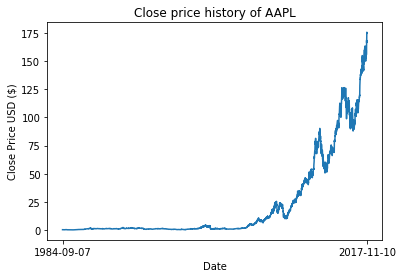

In [4]:
# Visualize closing price history
plt.title('Close price history of %s' % stock.upper())
plt.plot(df['Close'])
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.xticks([list(df.index.values)[0], list(df.index.values)[-1]])
plt.show()

# Functions

In [5]:
def prepare_data_autoreg(data, timestep, target_col, num_output):
    num_samples, num_features = data.shape[0], data.shape[1]
    x = np.empty((0, timestep, num_features))
    y = []
    excess = 0
    for i in range(timestep, len(data), num_output):
        if i+num_output <= len(data):
            datapoint = np.expand_dims(data[i-timestep:i,:], axis=0) # new datapoint with shape (1, timestep, num_features)
            x = np.r_[x, datapoint] 
            y.append(data[i:i+num_output,target_col])
        else:
            excess = len(data) - i
            break 

    return x, np.array(y), excess

In [8]:
def prepare_train_test(data, timestep, train_split=0.8, target_col=-1, num_output=1, scaled=False):
    
    # Reshape data if list or 1D array
    if type(data)==list or data.ndim==1:
        data = np.array(data).reshape(-1,1)

    # Split train and test data
    train_data_len = int(data.shape[0] * train_split) # Round off to nearest integer for index value
    train_data = data[:train_data_len] # first X% of data
    
    # Normalization if needed
    scaler = None
    if scaled:  
        scaler = MinMaxScaler(feature_range=(0,1))
        train_data = scaler.fit_transform(train_data)
        
    # Generate training and test dataset
    x_train, y_train, excess = prepare_data_autoreg(train_data, timestep, target_col, num_output)
    test_data = data[train_data_len - timestep - excess:] # last (1-X)% of data
    test_data = scaler.transform(test_data)
    x_test, y_test, _ = prepare_data_autoreg(test_data, timestep, target_col, num_output)

    return x_train, x_test, y_train, y_test, scaler

In [7]:
def build_lstm_default(timestep, features, nodes, num_output):
    lstm = Sequential()
    lstm.add(LSTM(nodes, return_sequences=True, input_shape=(timestep,features)))
    lstm.add(LSTM(nodes, return_sequences=False))
    lstm.add(Dense(25))
    lstm.add(Dense(num_output))
    lstm.compile(loss='mean_squared_error', optimizer='adam')
    return lstm

In [61]:
def evaluate_LSTM(data, model, scaler, **kwargs):
    
    # Define variables from arguments
    xtr, xts, ytr, yts = data[0], data[1], data[2], data[3]
    title = kwargs['title'] if 'title' in kwargs else 'Predicted Close Values by Univariate LSTM'
    show_loss = kwargs['show_loss'] if 'show_loss' in kwargs else 1
    show_plot = kwargs['show_plot'] if 'show_plot' in kwargs else 1
    
    # Check for missing args
    check_args = [k for k in ['actual_data','timestep'] if k not in kwargs]
    if show_plot and len(check_args):
        raise Exception('The followings arguments are missing: %s' % ', '.join(check_args))
        return
    if show_loss and 'hist' not in kwargs:
        raise Exception('Please provide the model history handle (hist=handle) for plotting loss.')
        return
        
    # Prediction
    ytr_pred = model.predict(xtr)
    yts_pred = model.predict(xts)

    ytr_pred_unscaled = np.ravel(scaler.inverse_transform(ytr_pred))
    yts_pred_unscaled = np.ravel(scaler.inverse_transform(yts_pred))
    ytr_actual = np.ravel(scaler.inverse_transform(ytr))
    yts_actual = np.ravel(scaler.inverse_transform(yts))

    # Get MSE
    mse_tr = mean_squared_error(ytr_actual, ytr_pred_unscaled, squared=False)
    mse_ts = mean_squared_error(yts_actual, yts_pred_unscaled, squared=False)

    # Visualize loss
    if show_loss:
        hist = kwargs['hist']
        plt.plot(hist.history['loss'])
        plt.plot(hist.history['val_loss'])
        plt.legend(['Training', 'Validation'])
        plt.xlabel('Epochs')
        plt.title('Loss (MSE) over Epochs')
        plt.show()
        print('RMSE (Train):', mse_tr)
        print('RMSE (Test):', mse_ts)

    # Visualize data
    if show_plot:
        
        actual_data, timestep = kwargs['actual_data'], kwargs['timestep']
        stock = ' (%s)'%kwargs['stock'].upper() if 'stock' in kwargs else ''
        ytr_end = ytr_actual.shape[0] + timestep
        yts_end = yts_actual.shape[0] + ytr_end
    
        dates = actual_data.index.values
    
        plt.figure(figsize=(8,5))
        plt.plot(actual_data['Close'], label='Actual')
        plt.plot(dates[timestep:ytr_end], ytr_pred_unscaled, label='Prediction (Train)\nRMSE = %.3f' % mse_tr)
        plt.plot(dates[ytr_end:yts_end], yts_pred_unscaled, label='Prediction (Test)\nRMSE = %.3f' % mse_ts)
        plt.xlabel('Date')
        plt.ylabel('Close Price USD ($)')
        plt.xticks([list(dates)[0], list(dates)[-1]])
        plt.title(title + stock)
        plt.legend()
        plt.show()
        
    return mse_tr, mse_ts

# Normal Train/Validation

We use the time series of **`Close`** values to forecast **`Close`** values. Perform a train-val/test split of 80/20, and normalize the training data. Then, define a variable `num_timesteps` to generate the datapoints. Each datapoint will have input features of dimensions `num_timesteps`, and output feature of dimension 1, which is the **`Close`** value after the preceeding `num_timesteps` **`Close`** values. Repeat this generation process for the validation dataset.

In [17]:
step = 55
lstm_data = df['Close'].values # create new df with only 'Close' column
xtr, xts, ytr, yts, scaler = prepare_train_test(lstm_data, step, train_split=0.8, scaled=True)
print(xtr.shape, ytr.shape)
print(xts.shape, yts.shape)

(6636, 55, 1) (6636, 1)
(1673, 55, 1) (1673, 1)


In [20]:
# Build LSTM model
lstm = build_lstm_default(timestep=step, features=1, nodes=45, num_output=ytr.shape[1])

# Train the model
start = time.time()
print('Training...', end=' ')
lstm_hist = lstm.fit(xtr, ytr, batch_size=32, epochs=30, validation_data=(xts, yts), verbose=False)
# lstm_hist = lstm.fit(xtr, ytr, batch_size=32, epochs=30, verbose=False)
end = time.time()
print('Done. Time taken: %.3fs' % (end-start))

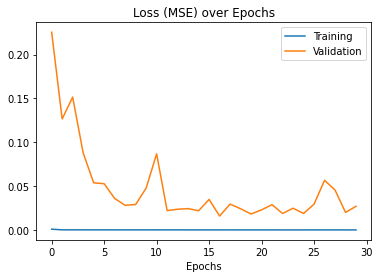

RMSE (Train): 0.2282927582064734
RMSE (Test): 7.601171743144761


In [21]:
evaluate_LSTM((xtr, xts, ytr, yts), lstm, scaler, hist=lstm_hist, show_plot=0);

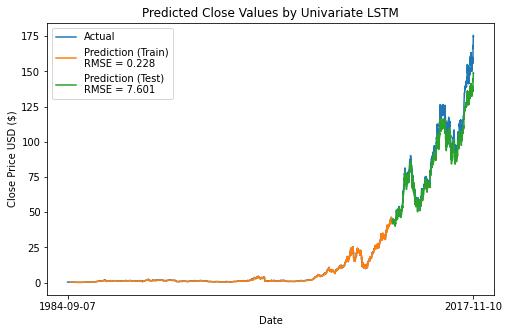

In [27]:
mse_tr_lstm, mse_ts_lstm = evaluate_LSTM((xtr, xts, ytr, yts), lstm, scaler, 
                                         show_loss=0, 
                                         actual_data=df, timestep=step);

# Predictive Validation Dataset

The following cell takes pretty long to run.

In [10]:
# Generation of test dataset and predict future values
curr_x = x_val[0].reshape(1,x_val[0].shape[0],1) # reshape to (1,num_timesteps,1)
y_val_pred2 = []
print('/%d:' % y_val_pred.shape[0])
for i in range(y_val_pred.shape[0]): # y_val_pred2 should have the same length as y_val
    pred = model.predict(curr_x)
    y_val_pred2.append(list(pred[0]))
    curr_x = np.r_[curr_x[0][1:], pred].reshape(1,x_val[0].shape[0],1)
    if not (i%100):
        print(i, end=' ')

y_val_pred2 = np.array(y_val_pred2).reshape(-1,1) # reshape to (num_samples, 1)
y_val_pred2 = scaler.inverse_transform(y_val_pred2)

0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 

MSE (predictive val data): 1871.158403822898


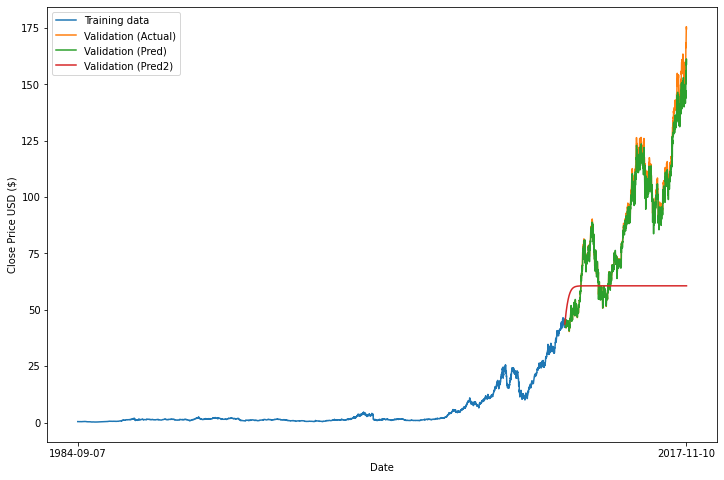

In [11]:
# Evaluation
print('MSE (predictive val data):',mean_squared_error(y_val, y_val_pred2))

# Visualize data
val['Predictions (Generative)'] = y_val_pred2

plt.figure(figsize=(12,8))
plt.plot(train['Close'], label='Training data')
plt.plot(val[['Close', 'Predictions', 'Predictions (Generative)']], 
         label=['Validation (Actual)','Validation (Pred)', 'Validation (Pred2)'])
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.xticks([list(df.index.values)[0], list(df.index.values)[-1]])
plt.legend()
plt.show()

# Hyperparameter Tuning
Varying n_timesteps, n_nodes/units, layers, n_epochs.

In [44]:
def build_default(timestep, nodes):
    lstm = Sequential()
    lstm.add(LSTM(nodes, return_sequences=True, input_shape=(timestep,1)))
    lstm.add(LSTM(nodes, return_sequences=False))
    lstm.add(Dense(25))
    lstm.add(Dense(1))
    lstm.compile(loss='mean_squared_error', optimizer='adam')
    return lstm

In [57]:
def tune_model(timestep, nodes, epochs, batch_size=32, build_model=build_default):
    
    # Generate training dataset
    xtr, ytr = [], []
    for i in range(timestep, len(scaled_train_data)):
        xtr.append(scaled_train_data[i-timestep:i,0])
        ytr.append(scaled_train_data[i,0])
    xtr, ytr = np.array(xtr), np.array(ytr) # convert to np arrays
    xtr = xtr.reshape(xtr.shape[0], timestep, 1) # reshape data

    # Generate validation data set
    val = dataset[train_data_len - timestep:, :]
    scaled_val = scaler.transform(val) # normalize using scaler fit to training data
    xval = []
    for i in range(timestep, len(scaled_val)):
        xval.append(scaled_val[i-timestep:i, 0])
    xval = np.array(xval) # convert to np array
    xval = xval.reshape(xval.shape[0], timestep, 1) # reshape data
    
    # Build LSTM model
    lstm = build_model(timestep, nodes)

    # Train the model
    lstm.fit(xtr, ytr, batch_size=batch_size, epochs=epochs, validation_data=(xval,scaler.transform(y_val)), verbose=False)
    
    # Prediction
    ytr_pred = lstm.predict(xtr)
    yval_pred = lstm.predict(xval)
    yval_pred = scaler.inverse_transform(yval_pred)
    
    # Evaluation
    mse_train = mean_squared_error(scaler.inverse_transform(ytr), scaler.inverse_transform(ytr_pred))
    mse_test = mean_squared_error(y_val, yval_pred)
    
    return mse_train, mse_test

### Number of timesteps

In [62]:
n_timesteps = [3,7,30,60,30*6,365] # 3 days, 1 week, 1 month, 2 months, half year, 1 year
eval_timesteps_dict = {
    'Timestep': [],
    'MSE (Train)': [],
    'MSE (Val)': [],
}

for timestep in n_timesteps:
#     print(timestep)
    
    mse_train, mse_test = tune_model(timestep, nodes=50, epochs=30, batch_size=32)
    
    # Evaluation and store in df
    eval_timesteps_dict['Timestep'].append(timestep)
    eval_timesteps_dict['MSE (Train)'].append(mse_train)
    eval_timesteps_dict['MSE (Val)'].append(mse_test)

eval_timesteps_df = pd.DataFrame(eval_timesteps_dict)
eval_timesteps_df.set_index('Timestep', inplace=True)
display(eval_timesteps_df)

,MSE (Train),MSE (Val)
Timestep,,
3,0.000036,130.172943
7,0.000051,9.497001
30,0.000027,49.622815
60,0.000050,124.956012
180,0.000039,16.836325
365,0.000024,20.203920


### Number of nodes/units

In [63]:
n_nodes = [10,30,50,100,150,200]
eval_nodes_dict = {
    'Nodes': [],
    'MSE (Train)': [],
    'MSE (Val)': [],
}

for nodes in n_nodes:
#     print(nodes)
    
    mse_train, mse_test = tune_model(timestep=60, nodes=nodes, epochs=30, batch_size=32)
    
    # Evaluation and store in df
    eval_nodes_dict['Nodes'].append(nodes)
    eval_nodes_dict['MSE (Train)'].append(mse_train)
    eval_nodes_dict['MSE (Val)'].append(mse_test)

eval_nodes_df = pd.DataFrame(eval_nodes_dict)
eval_nodes_df.set_index('Nodes', inplace=True)
display(eval_nodes_df)

,MSE (Train),MSE (Val)
Nodes,,
10,0.000050,227.587959
30,0.000064,51.051536
50,0.000046,72.301192
100,0.000031,5.930369
150,0.000069,33.088994
200,0.000026,22.872211


### Number of epochs

In [64]:
n_epochs = [10,30,50,100,200]
eval_epochs_dict = {
    'Epochs': [],
    'MSE (Train)': [],
    'MSE (Val)': [],
}

for epochs in n_epochs:
#     print(epochs)
    
    mse_train, mse_test = tune_model(timestep=60, nodes=50, epochs=epochs, batch_size=32)
    
    # Evaluation and store in df
    eval_epochs_dict['Epochs'].append(epochs)
    eval_epochs_dict['MSE (Train)'].append(mse_train)
    eval_epochs_dict['MSE (Val)'].append(mse_test)

eval_epochs_df = pd.DataFrame(eval_epochs_dict)
eval_epochs_df.set_index('Epochs', inplace=True)
display(eval_epochs_df)

,MSE (Train),MSE (Val)
Epochs,,
10,0.000072,139.772375
30,0.000032,15.622609
50,0.000023,71.215606
100,0.000025,86.191078
200,0.000042,584.373513


**Best params**

Number of timesteps: 7

Number of nodes: 100

Number of epochs: 30


### Best Parameters

In [65]:
best_timestep = 7

# Generate training dataset
xtr_best, ytr_best = [], []
for i in range(best_timestep, len(scaled_train_data)):
    xtr_best.append(scaled_train_data[i-best_timestep:i,0])
    ytr_best.append(scaled_train_data[i,0])
xtr_best, ytr_best = np.array(xtr_best), np.array(ytr_best) # convert to np arrays
xtr_best = xtr_best.reshape(xtr_best.shape[0], best_timestep, 1) # reshape data

# Generate test data set
val_best = dataset[train_data_len - best_timestep:, :]
scaled_val_best = scaler.transform(val_best) # normalize using scaler fit to training data
xval_best = []
for i in range(best_timestep, len(scaled_val_best)):
    xval_best.append(scaled_val_best[i-best_timestep:i, 0])
xval_best = np.array(xval_best) # convert to np array
xval_best = xval_best.reshape(xval_best.shape[0], best_timestep, 1) # reshape data

In [66]:
best_nodes = 100
best_epochs = 30

# Build LSTM model
model_best = Sequential()
model_best.add(LSTM(best_nodes, return_sequences=True, input_shape=(best_timestep,1)))
model_best.add(LSTM(best_nodes, return_sequences=False))
model_best.add(Dense(25))
model_best.add(Dense(1))
model_best.compile(loss='mean_squared_error',optimizer='adam')

# Train the model
history_best = model_best.fit(xtr_best, ytr_best, batch_size=32, epochs=best_epochs, validation_data=(xval_best,scaler.transform(y_val)))

Epoch 1/30
209/209 [==============================] - 10s 25ms/step - loss: 0.0011 - val_loss: 0.0597
Epoch 2/30
209/209 [==============================] - 4s 20ms/step - loss: 1.1323e-04 - val_loss: 0.0613
Epoch 3/30
209/209 [==============================] - 4s 20ms/step - loss: 8.7451e-05 - val_loss: 0.0542
Epoch 4/30
209/209 [==============================] - 4s 20ms/step - loss: 1.1680e-04 - val_loss: 0.0850
Epoch 5/30
209/209 [==============================] - 4s 21ms/step - loss: 1.1241e-04 - val_loss: 0.0955
Epoch 6/30
209/209 [==============================] - 4s 21ms/step - loss: 1.0257e-04 - val_loss: 0.0797
Epoch 7/30
209/209 [==============================] - 4s 20ms/step - loss: 1.2044e-04 - val_loss: 0.0421
Epoch 8/30
209/209 [==============================] - 4s 20ms/step - loss: 9.0433e-05 - val_loss: 0.1320
Epoch 9/30
209/209 [==============================] - 4s 21ms/step - loss: 8.5780e-05 - val_loss: 0.0495
Epoch 10/30
209/209 [==============================] - 4s 

MSE: 22.05924125391569


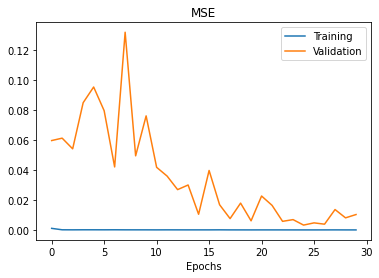

In [67]:
# Prediction
yval_best_pred = model_best.predict(xval_best)
# y_val_pred_noscale = y_val_pred
yval_best_pred = scaler.inverse_transform(yval_best_pred)

# Get MSE
print('MSE:',mean_squared_error(y_val, yval_best_pred))

plt.plot(history_best.history['loss'])
plt.plot(history_best.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.xlabel('Epochs')
plt.title('MSE')
plt.show()

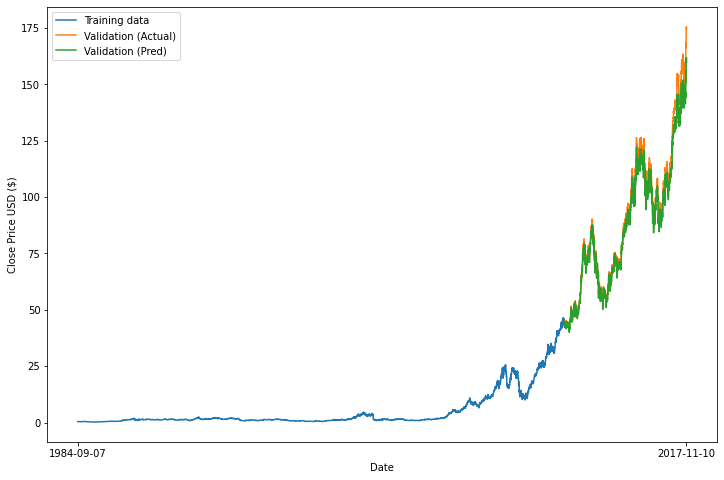

In [68]:
# Visualize data
val_best = df_close[train_data_len:].copy()
val_best['Predictions'] = yval_best_pred

plt.figure(figsize=(12,8))
plt.plot(train['Close'], label='Training data')
plt.plot(val_best[['Close', 'Predictions']], label=['Validation (Actual)','Validation (Pred)'])
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.xticks([list(df.index.values)[0], list(df.index.values)[-1]])
plt.legend()
plt.show()

# Different outputs

From the above, predictive generation of validation data is wildly inaccurate from the true values. For investors, this model will not be useful.

Instead of generating one close value from the previous 60 days of close values, we try two outputs:
1. 5 days of close values from the previous 30 days of values
2. Monthly returns (*price of month end* - *price of month start*) from the past month's return. This may not be very accurate however because we only have 3 years of data (i.e. 36 time observations).

## 1. Price in following 5 days given past 30 days data
The output of the model could be the price in the following five days (Price(t+1) to Price(t+5)) based on the past 30 days data.

In [29]:
step_week = 7

# 1 week
xtr_week, xts_week, ytr_week, yts_week, scaler_week = prepare_train_test(lstm_data, step_week, num_output=5, scaled=True)
lstm_week = build_lstm_default(step_week, 1, 55, num_output=5) # step, features, nodes, num_output
start = time.time()
print('Training...', end=' ')
lstm_week_hist = lstm_week.fit(xtr_week, ytr_week, batch_size=32, epochs=30, validation_data=(xts_week, yts_week), verbose=False)
end = time.time()
print('Done. Time taken: %.3fs' % (end-start))

In [34]:
print(xtr_week.shape, ytr_week.shape)
print(xts_week.shape, yts_week.shape)

(1336, 7, 1) (1336, 5)
(335, 7, 1) (335, 5)


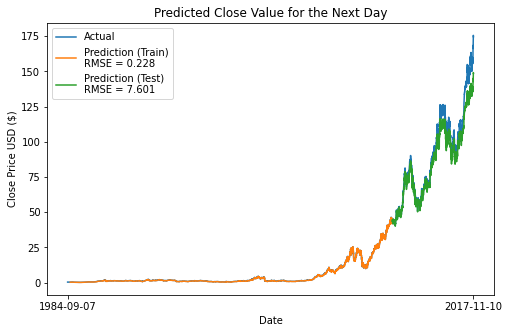

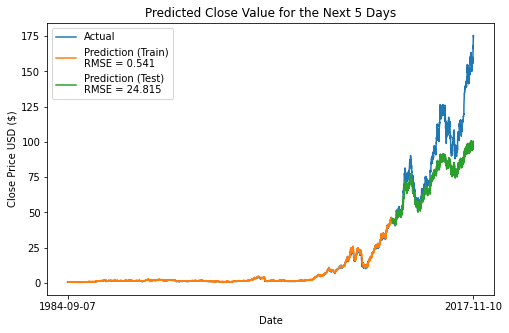

In [36]:
_, _ = evaluate_LSTM((xtr, xts, ytr, yts), lstm, scaler_best, 
                     show_loss=0,
                     actual_data=lstm_data, timestep=step,
                     title='Predicted Close Value for the Next Day')

mse_tr_week, mse_ts_week = evaluate_LSTM((xtr_week, xts_week, ytr_week, yts_week), lstm_week, scaler_week,
                                         show_loss=0,
                                         actual_data=lstm_data, timestep=step_week,
                                         title='Predicted Close Value for the Next 5 Days');

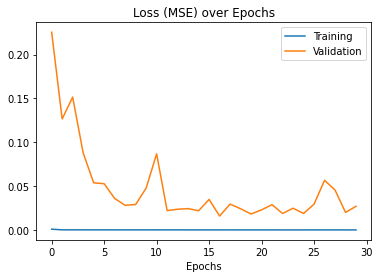

RMSE (Train): 0.5410730655425053
RMSE (Test): 24.815169632730644


In [39]:
evaluate_LSTM((xtr_week, xts_week, ytr_week, yts_week), lstm_week, scaler_week, hist=lstm_hist, show_plot=0);

### Predictive Test Dataset

In [19]:
# Generation of test dataset and predict future values
curr_x1 = x_val1[0].reshape(1,x_val1[0].shape[0],1) # reshape to (1,num_timesteps,1)
y_val1_pred2 = []
for i in range(y_val1_pred.shape[0]): # y_val_pred2 should have the same length as y_val
    pred = model1.predict(curr_x1)
    y_val1_pred2.append(list(pred[0]))
    curr_x1 = np.r_[curr_x1[0][num_output:], pred.reshape(-1,1)].reshape(1,x_val1[0].shape[0],1)
    if not (i%50):
        print(i, end=' ')

y_val1_pred2 = np.array(y_val1_pred2).reshape(-1,num_output) # reshape to (num_samples, num_output)
y_val1_pred2 = scaler.inverse_transform(y_val1_pred2)

0 50 100 150 200 250 300 

MSE (predictive val data): 8030.961010002017


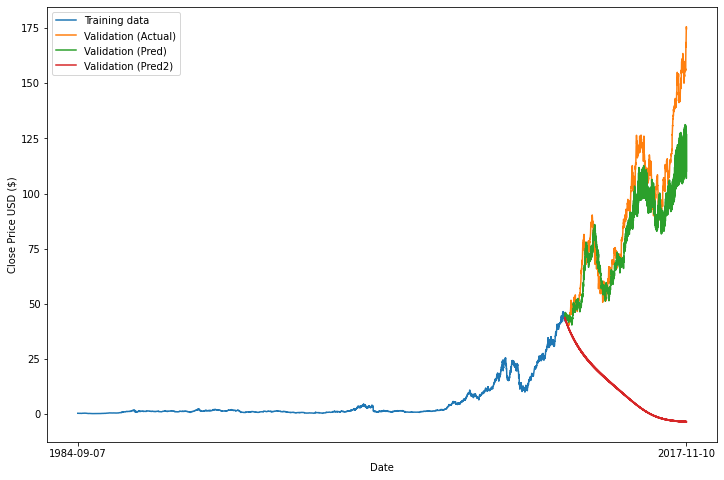

In [20]:
# Evaluation
print('MSE (predictive val data):',mean_squared_error(y_val1, y_val1_pred2))

# Visualize data
val1['Predictions (Generative)'] = np.ravel(y_val1_pred2)[:val1.shape[0]]

plt.figure(figsize=(12,8))
plt.plot(train['Close'], label='Training data')
plt.plot(val1[['Close', 'Predictions', 'Predictions (Generative)']], 
         label=['Validation (Actual)','Validation (Pred)', 'Validation (Pred2)'])
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.xticks([list(df.index.values)[0], list(df.index.values)[-1]])
plt.legend()
plt.show()

## 2. Predict Monthly Returns
Another practical setting is to predict the return in a time period. Return of one month is defined as the price change rate, that is *price_of_month_end* - *price_of_month_start* / *price_of_month_start*. Then your problem is formulated as that (for example) given the past 3 years data (could be monthly return, then you have 36 time observations), the model is to predict next month’s return.

In [35]:
df_close.head(10)

,Close,Close-scaled
Date,,
1984-09-07,0.42388,0.004179
1984-09-10,0.42134,0.004124
1984-09-11,0.42902,0.004290
1984-09-12,0.41618,0.004013
1984-09-13,0.43927,0.004512
1984-09-14,0.44566,0.004650
1984-09-17,0.45718,0.004899
1984-09-18,0.44052,0.004539
1984-09-19,0.43157,0.004345


,Start,End,Return
Month,,,
1984-09,0.42388,0.40081,-0.054426
1984-10,0.39186,0.39699,0.013091
1984-11,0.39956,0.39443,-0.012839
1984-12,0.38932,0.46487,0.194056
1985-01,0.44566,0.46357,0.040188


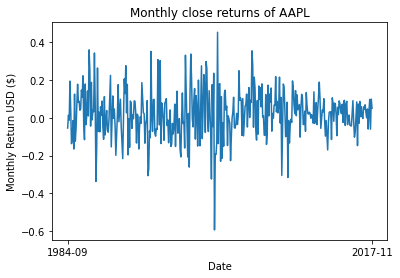

In [21]:
# Get DataFrame

df_close_cpy = df_close.copy()

get_month = lambda x: x[:-3] # returns yyyy-mm
df_close_cpy['month'] = df_close.index.map(lambda x: x[:-3])
df_close_cpy['day'] = df_close.index.map(lambda x: int(x[-2:]))

df_returns_dict = {'Month':[], 'Start':[], 'End':[], 'Return':[]}
for month in np.unique(df_close_cpy['month'].values):
    start_day = df_close_cpy[df_close_cpy['month']==month].day.values.min()
    end_day = df_close_cpy[df_close_cpy['month']==month].day.values.max()
    start_close = df_close_cpy[(df_close_cpy['month']==month) & (df_close_cpy['day']==start_day)]['Close'].values[0]
    end_close = df_close_cpy[(df_close_cpy['month']==month) & (df_close_cpy['day']==end_day)]['Close'].values[0]
    df_returns_dict['Month'].append(month)
    df_returns_dict['Start'].append(start_close)
    df_returns_dict['End'].append(end_close)
    df_returns_dict['Return'].append((end_close - start_close)/start_close)

df_close_returns = pd.DataFrame(df_returns_dict)
df_close_returns.set_index('Month', inplace=True)
display(df_close_returns.head())

# Visualize returns
plt.title('Monthly close returns of %s' % stock.upper())
plt.plot(df_close_returns['Return'])
plt.xlabel('Date')
plt.ylabel('Monthly Return USD ($)')
plt.xticks([list(df_close_returns.index.values)[0], list(df_close_returns.index.values)[-1]])
plt.show()

In [22]:
## Data Processing ##

dataset2 = df_close_returns['Return'].values.reshape(-1,1) # convert df to np array
train_data_len2 = math.ceil( len(dataset2) * 0.8 ) # length of training data

# Split train and test data
train_data2 = dataset2[:train_data_len2] # reshape to (num_samples, 1) for scaler
scaler2 = MinMaxScaler(feature_range=(0,1))
scaled_train_data2 = scaler2.fit_transform(train_data2) # only normalize with training data

df_close_returns['Return-scaled'] = scaler2.transform(dataset2)
x_train2, y_train2 = [], []

num_timesteps2 = 36 # 3 years

# Generate training dataset
for i in range(num_timesteps2, len(scaled_train_data2)):
    x_train2.append(scaled_train_data2[i-num_timesteps2:i,0])
    y_train2.append(scaled_train_data2[i,0])
    
x_train2, y_train2 = np.array(x_train2), np.array(y_train2) # convert to np arrays
x_train2 = x_train2.reshape(x_train2.shape[0], num_timesteps2, 1) # reshape data

# Generate test data set
val_data2 = dataset2[train_data_len2 - num_timesteps2:, :]
scaled_val_data2 = scaler2.transform(val_data2) # normalize using scaler fit to training data
x_val2 = []
y_val2 = dataset2[train_data_len2:, :] # validation target is unscaled
for i in range(num_timesteps2, len(scaled_val_data2)):
    x_val2.append(scaled_val_data2[i-num_timesteps2:i, 0])

x_val2 = np.array(x_val2) # convert to np array
x_val2 = x_val2.reshape(x_val2.shape[0], num_timesteps2, 1) # reshape data

In [23]:
print(x_train2.shape, y_train2.shape)
print(x_val2.shape, y_val2.shape)

(284, 36, 1) (284,)
(79, 36, 1) (79, 1)


In [33]:
# Build LSTM model
model2 = Sequential()
model2.add(LSTM(50, return_sequences=True, input_shape=(num_timesteps2,1)))
model2.add(LSTM(50, return_sequences=False))
model2.add(Dense(25))
model2.add(Dense(1))
model2.compile(loss='mean_squared_error',optimizer='adam')

# Train the model
history2 = model2.fit(x_train2, y_train2, batch_size=1, epochs=30, validation_data=(x_val2,scaler2.transform(y_val2)))

Epoch 1/30
284/284 [==============================] - 5s 13ms/step - loss: 0.0256 - val_loss: 0.0042
Epoch 2/30
284/284 [==============================] - 3s 9ms/step - loss: 0.0196 - val_loss: 0.0044
Epoch 3/30
284/284 [==============================] - 3s 10ms/step - loss: 0.0201 - val_loss: 0.0049
Epoch 4/30
284/284 [==============================] - 3s 10ms/step - loss: 0.0193 - val_loss: 0.0054
Epoch 5/30
284/284 [==============================] - 3s 10ms/step - loss: 0.0189 - val_loss: 0.0067
Epoch 6/30
284/284 [==============================] - 3s 9ms/step - loss: 0.0183 - val_loss: 0.0042
Epoch 7/30
284/284 [==============================] - 3s 9ms/step - loss: 0.0175 - val_loss: 0.0042
Epoch 8/30
284/284 [==============================] - 2s 9ms/step - loss: 0.0182 - val_loss: 0.0068
Epoch 9/30
284/284 [==============================] - 3s 9ms/step - loss: 0.0180 - val_loss: 0.0044
Epoch 10/30
284/284 [==============================] - 3s 10ms/step - loss: 0.0180 - val_loss: 0

MSE: 0.005107049749579087


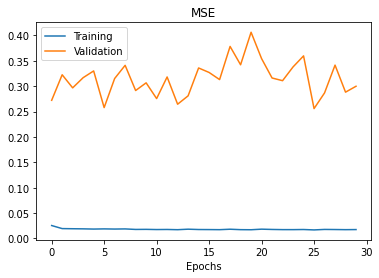

In [29]:
# Prediction
y_val2_pred = model2.predict(x_val2)
y_val2_pred = scaler2.inverse_transform(y_val2_pred)

# Get MSE
print('MSE:',mean_squared_error(y_val2, y_val2_pred))

plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.xlabel('Epochs')
plt.title('MSE')
plt.show()

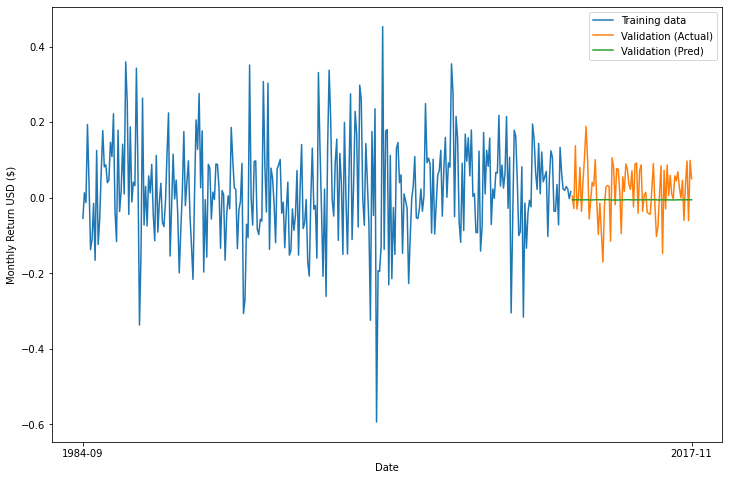

In [30]:
# Visualize data
train2 = df_close_returns[:train_data_len2]
val2 = df_close_returns[train_data_len2:].copy()
val2['Predictions'] = y_val2_pred

plt.figure(figsize=(12,8))
plt.plot(train2['Return'], label='Training data')
plt.plot(val2[['Return', 'Predictions']], label=['Validation (Actual)','Validation (Pred)'])
plt.xlabel('Date')
plt.ylabel('Monthly Return USD ($)')
plt.xticks([list(df_close_returns.index.values)[0], list(df_close_returns.index.values)[-1]])
plt.legend()
plt.show()

## Out-sample Performance

This section grabs historical stock data from Yahoo as true unseen data and shows the performance of the model

MSE (Model 0):  1.5681150440074705
MSE (Model 1):  44.192677348387285


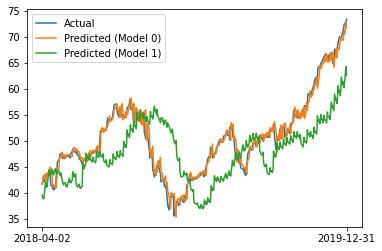

In [27]:
## Test model from unseen data ## 

# Get the quote
start_date = '2018-01-01'
end_date = '2019-12-31'

quote = web.DataReader(stock.upper(), data_source='yahoo', start=start_date, end=end_date) # get unseen test stock data from Yahoo
df_test = quote.filter(['Close']) # create new df

test_data = df_test.values
scaled_test_data = scaler.transform(test_data) # scale

# Generate test datapoints for prediction
# Normal
x_test, x_test1 = [], []
for i in range(num_timesteps, len(scaled_test_data)-1):
    x_test.append(scaled_test_data[i-num_timesteps:i,0])
x_test = np.array(x_test)
x_test = x_test.reshape(x_test.shape[0], num_timesteps, 1)

# Model1: Price for 5 days after 30 days
for i in range(num_timesteps1, len(scaled_test_data), num_output):
    if i+num_output < len(scaled_test_data):
        x_test1.append(scaled_test_data[i-num_timesteps1:i,0])
    else:
        break
x_test1 = np.array(x_test1)
x_test1 = x_test1.reshape(x_test1.shape[0], num_timesteps1, 1)

# Prediction
# Normal model
y_test_pred = model.predict(x_test)
y_test_pred = scaler.inverse_transform(y_test_pred) # unscale

# Model 1
y_test1_pred = model1.predict(x_test1)
y_test1_pred = scaler.inverse_transform(y_test1_pred) # unscale
y_test1_pred = np.ravel(y_test1_pred).reshape(-1,1)
# print(y_test_pred.shape, y_test1_pred.shape)

# Store in df
df_test_pred = df_test.iloc[num_timesteps+1: , :].copy() # create df for actual data after ~timestep~
df_test_pred['Pred0'] = y_test_pred # add column for predicted data
df_test_pred['Pred1'] = y_test1_pred[:y_test_pred.shape[0]] # add column for prediced data

# Evaluation
print('MSE (Model 0): ', mean_squared_error(df_test_pred['Close'].values, df_test_pred['Pred0'].values))
print('MSE (Model 1): ', mean_squared_error(df_test_pred['Close'].values, df_test_pred['Pred1'].values))

# Visualize prediction
plt.plot(df_test_pred[['Close', 'Pred0', 'Pred1']], label=['Actual','Predicted (Model 0)','Predicted (Model 1)'])
plt.legend()
plt.xticks([list(df_test_pred.index.values)[0], list(df_test_pred.index.values)[-1]])
plt.show()

## Models on Different Stock

In [50]:
up_stocks = ['aapl','ibm'] # upward trends
both_stocks = ['xhr','mik'] # bi-directional trends
down_stocks = ['sypr','ypf'] # downward trends

diff_stocks = {'data':{},'model':{},'mse_tr':{},'mse_ts':{}}

for stock in up_stocks+both_stocks+down_stocks:
    
    # Import stock data
    df_tmp = pd.read_csv('../Data/Stocks/%s.us.txt' % stock, index_col=0)
    df_tmp.drop('OpenInt', inplace=True, axis=1) # OpenInt column seems to be useless
    data = df_tmp['Close'].values
    
    # Training, prediction, evaluation
    xtr_tmp, xts_tmp, ytr_tmp, yts_tmp, scaler_tmp = prepare_train_test(data, step, scaled=True)
    
    lstm_tmp = build_lstm_default(step, 1, 45, num_output=1) # step, features, nodes, num_output
    print('Training (%s)...' % stock, end=' ')
    start = time.time()
    lstm_tmp.fit(xtr_tmp, ytr_tmp, batch_size=32, epochs=30, validation_data=(xts_tmp, yts_tmp), verbose=False)
    end = time.time()
    print('Done. Time taken: %.3fs' % (end-start))
    
    diff_stocks['data'][stock] = (df_tmp, xtr_tmp, xts_tmp, ytr_tmp, yts_tmp, scaler_tmp)
    diff_stocks['model'][stock] = lstm_tmp

Training (aapl)... Done. Time taken: 130.079s
Training (ibm)... Done. Time taken: 221.814s
Training (xhr)... Done. Time taken: 17.347s
Training (mik)... Done. Time taken: 19.137s
Training (sypr)... Done. Time taken: 54.789s
Training (ypf)... Done. Time taken: 52.361s


INCREASING


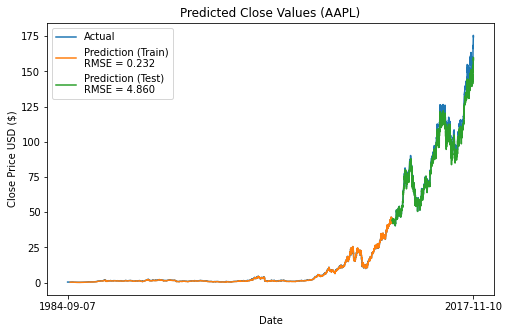

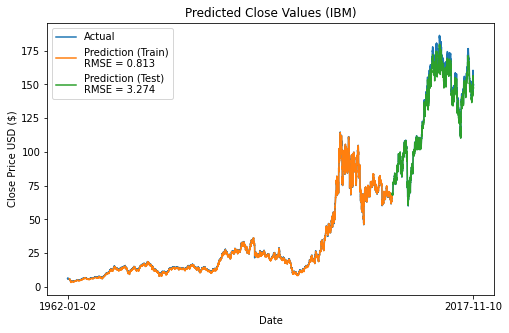

In [62]:
print('INCREASING')
for stock in up_stocks:
    data = diff_stocks['data'][stock]
    model = diff_stocks['model'][stock]
    mse_tr_tmp, mse_ts_tmp = evaluate_LSTM(data[1:5], model, data[-1],
                                           show_loss=0,
                                           actual_data=data[0], timestep=step, stock=stock,
                                           title='Predicted Close Values')
    diff_stocks['mse_tr'][stock] = mse_tr_tmp
    diff_stocks['mse_ts'][stock] = mse_ts_tmp

UP & DOWN


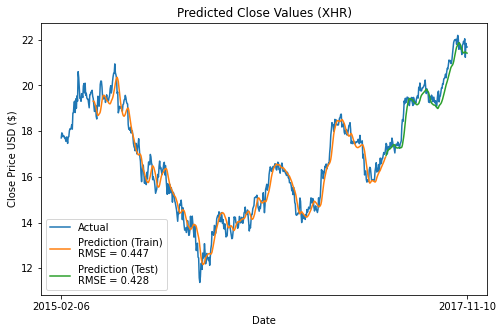

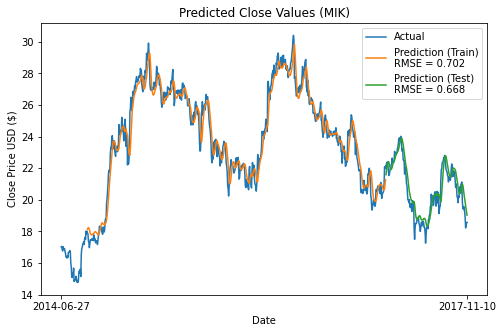

In [63]:
print('UP & DOWN')
for stock in both_stocks:
    data = diff_stocks['data'][stock]
    model = diff_stocks['model'][stock]
    mse_tr_tmp, mse_ts_tmp = evaluate_LSTM(data[1:5], model, data[-1],
                                           show_loss=0,
                                           actual_data=data[0], timestep=step, stock=stock,
                                           title='Predicted Close Values')
    diff_stocks['mse_tr'][stock] = mse_tr_tmp
    diff_stocks['mse_ts'][stock] = mse_ts_tmp

DOWN


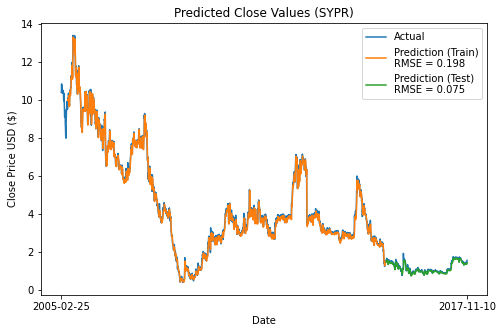

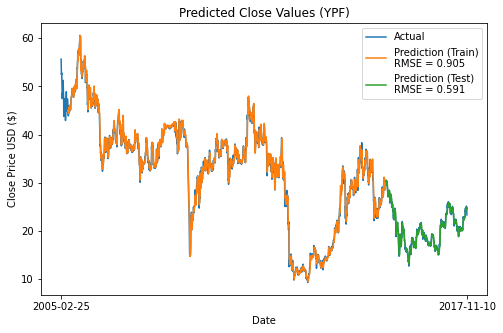

In [64]:
print('DOWN')
for stock in down_stocks:
    data = diff_stocks['data'][stock]
    model = diff_stocks['model'][stock]
    mse_tr_tmp, mse_ts_tmp = evaluate_LSTM(data[1:5], model, data[-1],
                                           show_loss=0,
                                           actual_data=data[0], timestep=step, stock=stock,
                                           title='Predicted Close Values')
    diff_stocks['mse_tr'][stock] = mse_tr_tmp
    diff_stocks['mse_ts'][stock] = mse_ts_tmp

In [60]:
print('RMSE for all models')
evaluate_df_dict = {}
evaluate_df_dict['Stock'] = diff_stocks['mse_tr'].keys()
evaluate_df_dict['RMSE (Train)'] = diff_stocks['mse_tr'].values()
evaluate_df_dict['RMSE (Test)'] = diff_stocks['mse_ts'].values()
evaluate_df = pd.DataFrame(evaluate_df_dict)
evaluate_df.set_index('Stock', inplace=True)
display(evaluate_df)

RMSE for all models


,RMSE (Train),RMSE (Test)
Stock,,
aapl,0.232199,4.860260
ibm,0.812516,3.274172
xhr,0.447277,0.428205
mik,0.701557,0.668061
sypr,0.197656,0.075497
ypf,0.904840,0.590916
